In [20]:
import sys
sys.path.append(".")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.notebook import tqdm as tqdm
from Models import SimpleLogisticModel
from Datasets import CustomTensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
%reload_ext autoreload
%autoreload 2

# Pytorch' NN

## Linear regression with one variable 

In [3]:
data = np.loadtxt('ex2data1.txt', delimiter=',')
X, Y = data[:,:2], data[:,2]

Datasets

In [4]:
train_ds = CustomTensorDataset(features=X, y=Y)

In [5]:
for i in range(5):
    x, y = train_ds[i]
    print(f'X: {x}, Y: {y}')

X: tensor([-1.6022,  0.6383], dtype=torch.float64), Y: tensor([0.], dtype=torch.float64)
X: tensor([-1.8263, -1.2075], dtype=torch.float64), Y: tensor([0.], dtype=torch.float64)
X: tensor([-1.5390,  0.3613], dtype=torch.float64), Y: tensor([0.], dtype=torch.float64)
X: tensor([-0.2821,  1.0864], dtype=torch.float64), Y: tensor([1.], dtype=torch.float64)
X: tensor([0.6915, 0.4934], dtype=torch.float64), Y: tensor([1.], dtype=torch.float64)


Dataloders

In [6]:
train_dl = DataLoader(train_ds, batch_size=len(train_ds))

### Plotting de data

In [7]:
exam_score_1, exam_score_2 = X[:,0], X[:,1]

In [8]:
labels = np.array(list(map(lambda student: 'Admitted' if student == 1 else 'Not admitted', Y)))

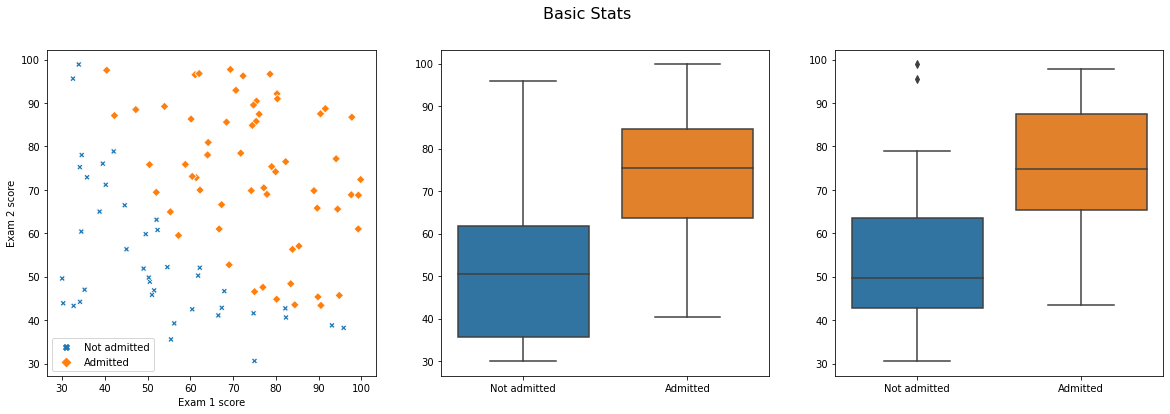

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Basic Stats', fontsize=16)

sns.scatterplot(x=exam_score_1, y=exam_score_2, hue=labels, style=labels, ax=ax1, markers={'Admitted': 'D', 'Not admitted': 'X'})
ax1.set_xlabel('Exam 1 score')
ax1.set_ylabel('Exam 2 score')

sns.boxplot(x=labels, y=exam_score_1, ax=ax2)
sns.boxplot(x=labels, y=exam_score_2, ax=ax3)

plt.show()

### NN Model Class

In [10]:
torch.set_default_dtype(torch.double)

In [11]:
hidden_size = 6

### Training the net

In [12]:
model = SimpleLogisticModel(2, hidden_size, 1)
optimizer = optim.SGD(model.parameters(), lr=3e-2)
bceloss_fn = nn.BCELoss(reduction='mean')

In [13]:
model

SimpleLogisticModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=6, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [14]:
losses = model.fit(train_dl=train_dl, epochs=1000, loss_fn=bceloss_fn, opt=optimizer)

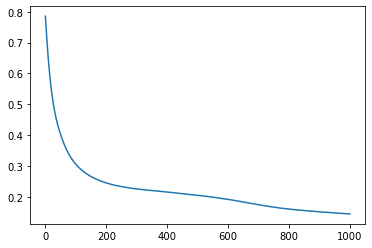

In [15]:
plt.plot(range(1000), losses)

In [16]:
x_train, y_train = train_ds.reverse_transform()

### Validating the net

In [17]:
y_train_pred = model.predict(train_dl).numpy().squeeze()

In [18]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9904166666666667


In [31]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.95


In [30]:
dummy_pred = model.predict(
    DataLoader(
        CustomTensorDataset(np.array([[45., .85]]), np.array([[1]])), batch_size=1
    )
).numpy().squeeze()
dummy_pred

array(nan)

In [22]:
x_train, y_train = train_ds.reverse_transform()

### Plotting results

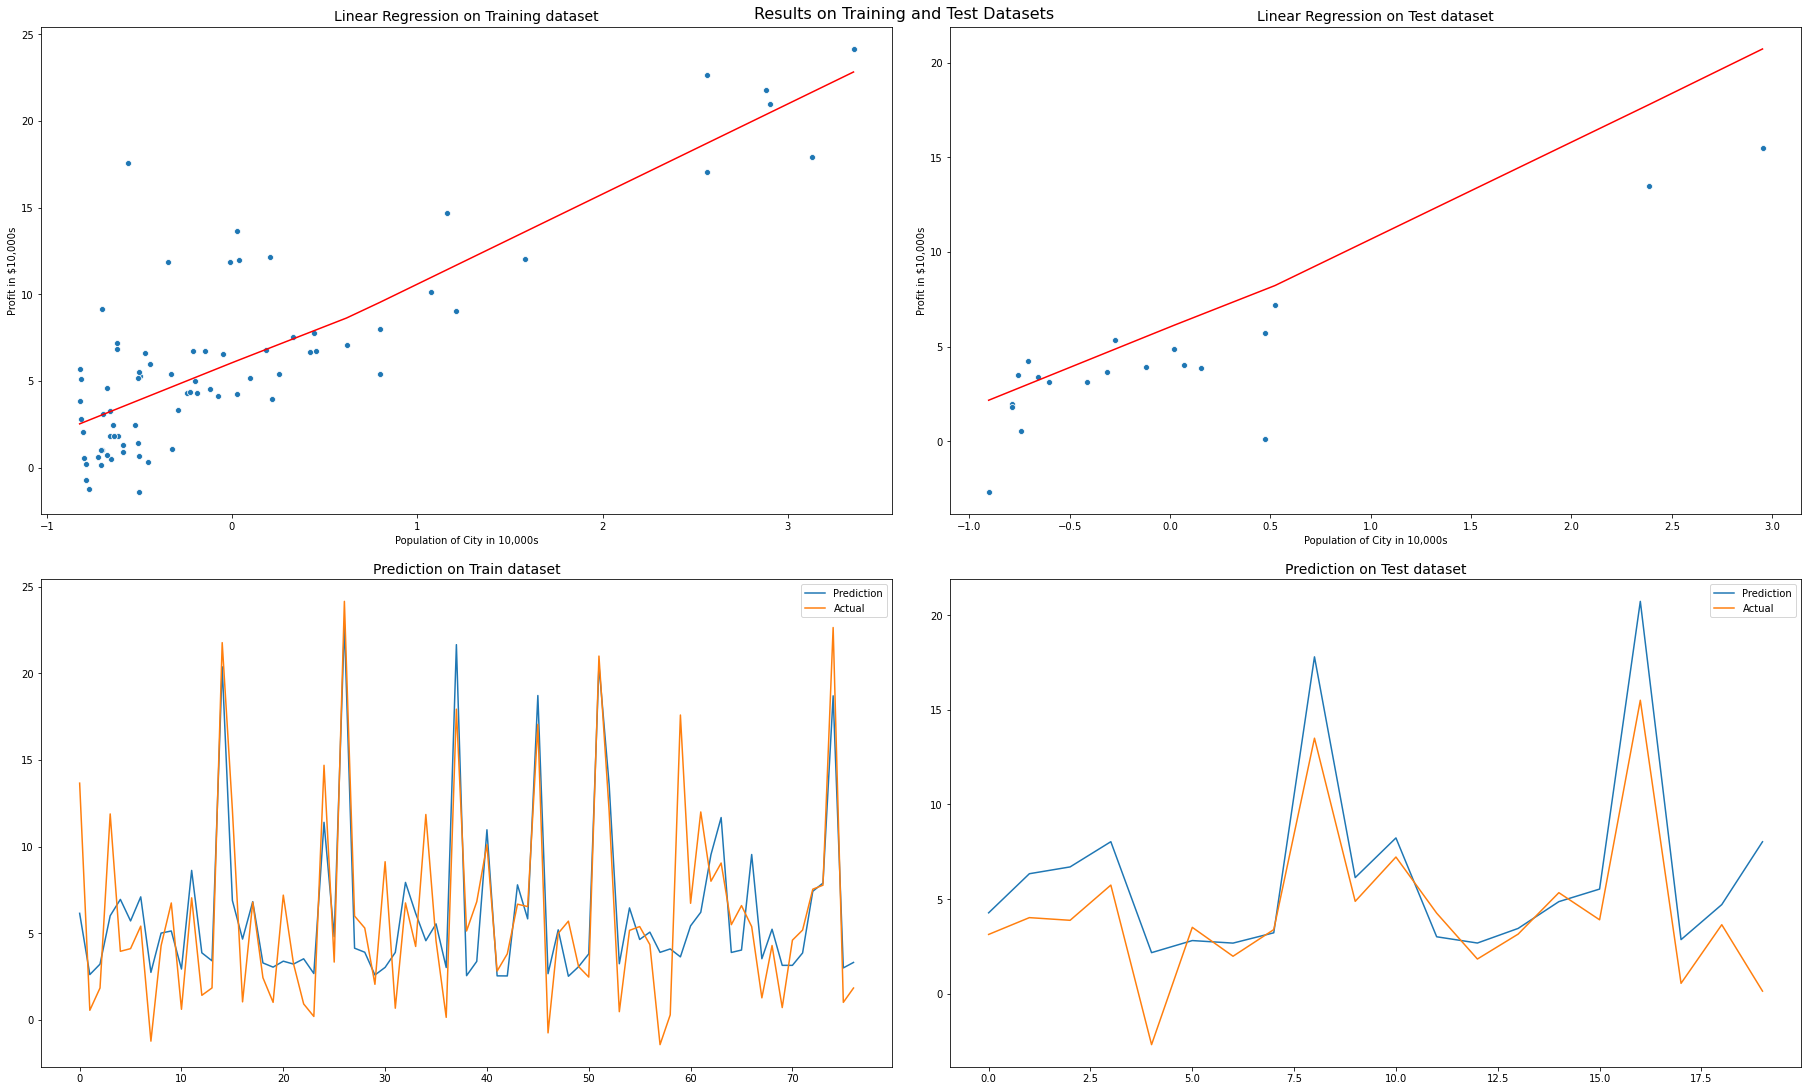

In [23]:
fig = plt.figure(constrained_layout=True, figsize=(25, 15))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])

fig.suptitle('Results on Training and Test Datasets', fontsize=16, y=1)

ax1.set_title('Linear Regression on Training dataset', fontsize=14)
sns.scatterplot(x=x_train, y=y_train, ax=ax1)
ax1.set_xlabel('Population of City in 10,000s')
ax1.set_ylabel('Profit in $10,000s')
sns.lineplot(x_train, y_train_pred, color='red', ax=ax1)

ax2.set_title('Linear Regression on Test dataset', fontsize=14)
sns.scatterplot(x=x_test, y=y_test, ax=ax2)
ax2.set_xlabel('Population of City in 10,000s')
ax2.set_ylabel('Profit in $10,000s')
sns.lineplot(x_test, y_test_pred, color='red', ax=ax2)

sns.lineplot(y=y_train_pred, x=range(len(y_train_pred)), ax=ax3, label='Prediction')
sns.lineplot(y=y_train, x=range(len(y_train)), ax=ax3, label='Actual')
ax3.set_title('Prediction on Train dataset', fontsize=14)

sns.lineplot(y=y_test_pred, x=range(len(y_test_pred)), ax=ax4, label='Prediction')
sns.lineplot(y=y_test, x=range(len(y_test)), ax=ax4, label='Actual')
ax4.set_title('Prediction on Test dataset', fontsize=14)

plt.show()